<a href="https://www.kaggle.com/code/iamommpatel/indian-weather-predictor?scriptVersionId=170923057" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory1
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-olympiad-forecasting-indias-weather/NM Weather Data in India from 1901 to 2017 - Weather Data in India from 1901 to 2017.csv


# Importing Essentials !!

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

Loading Dataset


In [3]:
df = pd.read_csv("/kaggle/input/ml-olympiad-forecasting-indias-weather/NM Weather Data in India from 1901 to 2017 - Weather Data in India from 1901 to 2017.csv")

In [4]:
# Melt the data and parse the date using method chaining
melted_df = (
    df.melt(id_vars='YEAR', value_vars=df.columns[1:])
    .assign(Date=lambda x: pd.to_datetime(x['variable'] + ' ' + x['YEAR'].astype(str), format='%m %Y'))
    .rename(columns={'YEAR': 'Year', 'variable': 'Month', 'value': 'Temperature'})
    .sort_values(by='Date')
    .reset_index(drop=True)
)
melted_df

,Year,Month,Temperature,Date
0,1901,1,17.99,1901-01-01
1,1901,2,19.43,1901-02-01
2,1901,3,23.49,1901-03-01
3,1901,4,26.41,1901-04-01
4,1901,5,28.28,1901-05-01
...,...,...,...,...
1399,2017,8,28.12,2017-08-01
1400,2017,9,28.11,2017-09-01
1401,2017,10,27.24,2017-10-01
1402,2017,11,23.92,2017-11-01


In [5]:
melted_df.shape

(1404, 4)

In [6]:
melted_df.describe() #basic statistical analysis

,Year,Temperature,Date
count,1404.000000,1404.000000,1404
mean,1959.000000,24.294160,1959-06-16 20:02:03.076923072
min,1901.000000,17.250000,1901-01-01 00:00:00
25%,1930.000000,21.067500,1930-03-24 06:00:00
50%,1959.000000,25.570000,1959-06-16 00:00:00
75%,1988.000000,27.240000,1988-09-08 12:00:00
max,2017.000000,30.780000,2017-12-01 00:00:00
std,33.785791,3.516446,NaN


In [7]:
#MELTED DF2
melted_df2 = pd.melt(df, id_vars='YEAR', value_vars=df.columns[1:]).assign(Date=lambda x: pd.to_datetime(x['variable'] + ' ' + x['YEAR'].astype(str), format='%m %Y')).rename(columns={'YEAR': 'Year', 'variable': 'Month', 'value': 'Temperature'}).reset_index(drop=True)

melted_df2.head()

,Year,Month,Temperature,Date
0,1901,1,17.99,1901-01-01
1,1902,1,19.00,1902-01-01
2,1903,1,18.32,1903-01-01
3,1904,1,17.77,1904-01-01
4,1905,1,17.40,1905-01-01


# Rapid Data Exploration using Pandas Profiling

In [8]:
pip install ydata-profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 52.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.8.2 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.25.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5

In [9]:
import ydata_profiling as ypf

profile = ypf.ProfileReport(melted_df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The above profiling concludes that we have got a very simple, clean and balanced dataset without any null values. 

# **Performing EDA !!**

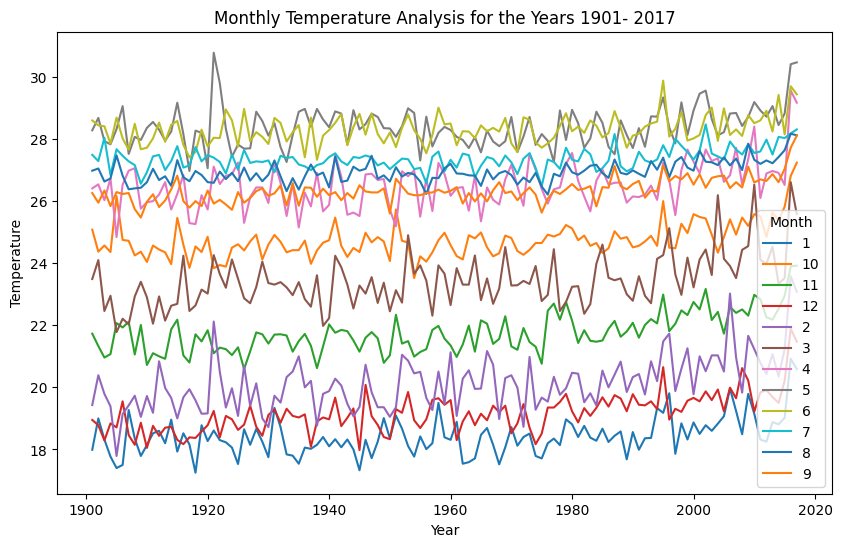

In [10]:
# Melt the month data (1,2,3...12) to single column month (column 1) and temperature (column 2) for each year
new_df = df.melt(id_vars=["ID","YEAR"], var_name="Month", value_name="Temperature")

# Reshape to get month as column names
df_reshape = new_df.pivot_table(
    values="Temperature", index="YEAR", columns="Month"
)
# Plot line chart
df_reshape.plot(kind="line", figsize=(10, 6))
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.title("Monthly Temperature Analysis for the Years 1901- 2017")
plt.legend(title="Month")
plt.show()


Identifying sudden spikes in monthly temperature variations, potentially indicative of outliers influenced by factors such as global warming or natural disasters

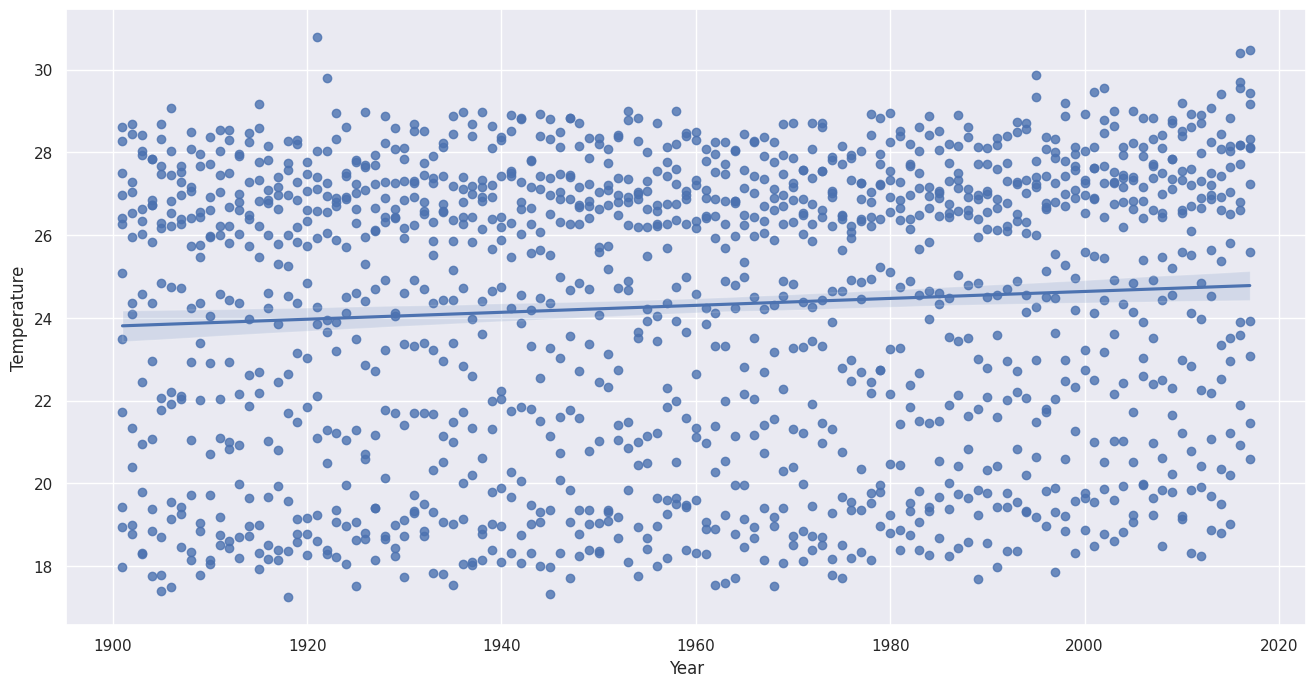

In [11]:
#Observing Increase in Temperature towards recent years.
sns.set()
plt.figure(figsize=(16,8))
sns.regplot(x = "Year",y="Temperature",fit_reg = True,data=melted_df)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

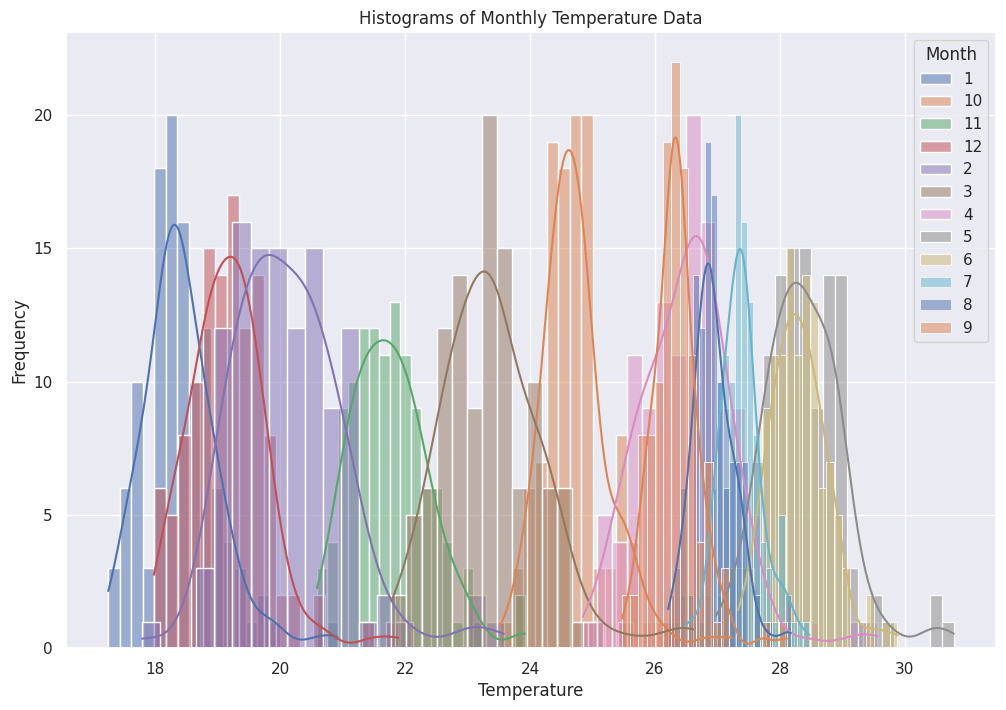

In [12]:
# Plot histograms for each month
plt.figure(figsize=(12, 8))
for column in df_reshape.columns:
    if column not in ['ID', 'YEAR']:
        sns.histplot(df_reshape[column], kde=True, label=column, bins=20)

plt.title('Histograms of Monthly Temperature Data')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(title='Month')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


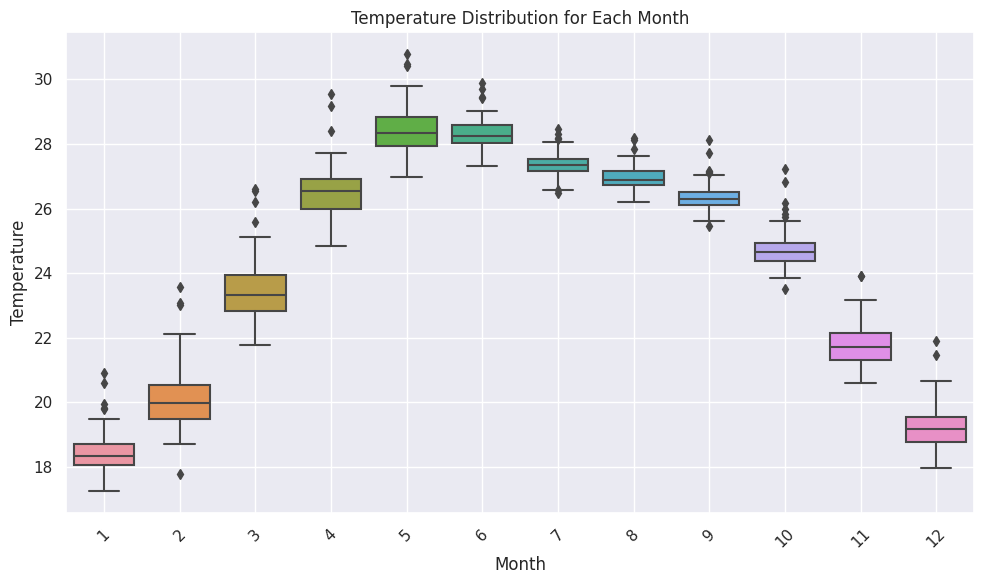

In [13]:
#ordering the month in sequential order
order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
new_df['Month'] = pd.Categorical(new_df['Month'], categories=order, ordered=True)

# To check outliers and central tendency we create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=new_df, x='Month', y='Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.title('Temperature Distribution for Each Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


We does not want to remove much of the outliers as they are mostly occured in recent year due to climate change. so removing them would affect our model from predicting future temperatures

#   Models Training and Tesing

In [14]:
melted_df.isnull().sum()

Year           0
Month          0
Temperature    0
Date           0
dtype: int64

In [15]:
#Splitting X and y for melted_df1
df2 = melted_df[['Year', 'Month', 'Temperature']].copy()
df2 = pd.get_dummies(df2)
y = df2[['Temperature']]
X = df2.drop(columns='Temperature')
X

,Year,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
0,1901,True,False,False,False,False,False,False,False,False,False,False,False
1,1901,False,False,False,False,True,False,False,False,False,False,False,False
2,1901,False,False,False,False,False,True,False,False,False,False,False,False
3,1901,False,False,False,False,False,False,True,False,False,False,False,False
4,1901,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,2017,False,False,False,False,False,False,False,False,False,False,True,False
1400,2017,False,False,False,False,False,False,False,False,False,False,False,True
1401,2017,False,True,False,False,False,False,False,False,False,False,False,False
1402,2017,False,False,True,False,False,False,False,False,False,False,False,False


In [16]:
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=119) #112, 119 , 1, 190

(1404, 13) (1404, 1)


#### M1 : Linear Regression


In [17]:
#loading and training Linear Regression Model
m1 = LinearRegression()
m1.fit(X_train, y_train)
m1_y_pred = m1.predict(X_test)
m1_y_pred
print("Linear Regression: R2 Score:", r2_score(y_test, m1_y_pred))

Linear Regression: R2 Score: 0.9779756824646342


In [18]:
#Predicting 2018 Values
next_year = melted_df[melted_df['Year'] == 2017][['Year', 'Month']]
next_year.Year.replace(2017, 2018, inplace=True)
next_year = pd.get_dummies(next_year)
forecast_lr = m1.predict(next_year)

/tmp/ipykernel_18/3611415463.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  next_year.Year.replace(2017, 2018, inplace=True)


In [19]:
forecast_lr

array([[18.92016318],
       [20.68471251],
       [23.99338955],
       [27.06723282],
       [28.90123238],
       [28.8360498 ],
       [27.88308319],
       [27.46891789],
       [26.89433631],
       [25.25625006],
       [22.29517522],
       [19.65124906]])

In [20]:
# Transforming the linear regression predicted values to Dataframe
linear_reg = pd.DataFrame({'ID': range(0, 12),'Month' : range(1,13) })
linear_reg['Temperature'] = forecast_lr
linear_reg['Year'] = 2018
linear_reg


,ID,Month,Temperature,Year
0,0,1,18.920163,2018
1,1,2,20.684713,2018
2,2,3,23.993390,2018
3,3,4,27.067233,2018
4,4,5,28.901232,2018
5,5,6,28.836050,2018
6,6,7,27.883083,2018
7,7,8,27.468918,2018
8,8,9,26.894336,2018
9,9,10,25.256250,2018


# M2: Decision Tree Regressor


In [21]:
#loading and training Decision Tree
m2 = DecisionTreeRegressor()
m2.fit(X_train, y_train)
m2_pred = m2.predict(X_test)
m2_y_pred = m2.predict(X_test)
print("Decision Tree Regression: R2 Score:", r2_score(y_test, m2_y_pred))

Decision Tree Regression: R2 Score: 0.9581542773127842


In [22]:
#Predicting 2018 Values
forecast_dt = m2.predict(next_year)

In [23]:
# Transforming the Decision Tree regression predicted values to Dataframe
DT_reg = pd.DataFrame({'ID': range(0, 12),'Month' : range(1,13) })
DT_reg['Temperature'] = forecast_dt
DT_reg['Year'] = 2018
DT_reg

,ID,Month,Temperature,Year
0,0,1,20.92,2018
1,1,2,23.08,2018
2,2,3,25.58,2018
3,3,4,29.17,2018
4,4,5,30.47,2018
5,5,6,29.44,2018
6,6,7,28.31,2018
7,7,8,28.12,2018
8,8,9,28.11,2018
9,9,10,27.24,2018


# M3: XGboost Regressor

In [24]:
#loading and training XGboost Regressor
from xgboost import XGBRegressor
m3 = XGBRegressor()
m3.fit(X_train, y_train)
m3_y_pred = m3.predict(X_test)
print("Xgboost Regression: R2 Score:", r2_score(y_test, m3_y_pred))

Xgboost Regression: R2 Score: 0.9768885578854352


In [25]:
#Predicting 2018 Values
forecast_xgb = m3.predict(next_year)

In [26]:
# Transforming the XGboost regressor predicted values to Dataframe
xgb_reg = pd.DataFrame({'ID': range(0, 12),'Month' : range(1,13) })
xgb_reg['Temperature'] = forecast_xgb
xgb_reg['Year'] = 2018
xgb_reg

,ID,Month,Temperature,Year
0,0,1,20.965242,2018
1,1,2,23.176565,2018
2,2,3,25.722076,2018
3,3,4,29.160328,2018
4,4,5,30.367857,2018
5,5,6,29.463146,2018
6,6,7,28.284067,2018
7,7,8,28.174038,2018
8,8,9,27.969236,2018
9,9,10,27.179722,2018


# M4: Gradient Boosting Regressor

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.05],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 1],
}

m4 = GradientBoostingRegressor()

gs = GridSearchCV(m4, param_grid, cv=9, scoring='r2')
gs.fit(X_train, y_train.values.ravel())
m4 = gs.best_estimator_
m4.fit(X_train, y_train.values.ravel())
m4_y_pred = m4.predict(X_test)

In [28]:
#Predicting 2018 Values
forecast_gb = m4.predict(next_year)
print("Gradient boosting : R2 Score:", r2_score(y_test, m4_y_pred))

Gradient boosting : R2 Score: 0.9800246235861243


In [29]:
# Transforming the Gradient Boosting regression predicted values to Dataframe
order = ['Year','Month','Temperature','Date']
GB_reg = pd.DataFrame({'ID': range(0, 12),'Month' : range(1,13) })
GB_reg['Date'] = pd.to_datetime(GB_reg['Month'].astype(str) + ' ' + '2018', format='%m %Y')
GB_reg['Temperature'] = forecast_gb
GB_reg['Year'] = 2018
GB_reg = GB_reg.drop(columns="ID")
GB_reg = GB_reg[order]
GB_reg

,Year,Month,Temperature,Date
0,2018,1,21.144753,2018-01-01
1,2018,2,23.019828,2018-02-01
2,2018,3,25.786756,2018-03-01
3,2018,4,29.151980,2018-04-01
4,2018,5,30.593936,2018-05-01
5,2018,6,29.659182,2018-06-01
6,2018,7,28.456354,2018-07-01
7,2018,8,28.225079,2018-08-01
8,2018,9,27.957735,2018-09-01
9,2018,10,26.944577,2018-10-01


In [30]:
GB_reg.reset_index(drop=True, inplace=True)
GB_reg.index = melted_df.index[-1] + 1 + GB_reg.index
melted_df2 = pd.concat([melted_df,GB_reg])
melted_df2.tail(20)

,Year,Month,Temperature,Date
1396,2017,5,30.470000,2017-05-01
1397,2017,6,29.440000,2017-06-01
1398,2017,7,28.310000,2017-07-01
1399,2017,8,28.120000,2017-08-01
1400,2017,9,28.110000,2017-09-01
1401,2017,10,27.240000,2017-10-01
1402,2017,11,23.920000,2017-11-01
1403,2017,12,21.470000,2017-12-01
1404,2018,1,21.144753,2018-01-01
1405,2018,2,23.019828,2018-02-01


In [31]:
melted_df2

,Year,Month,Temperature,Date
0,1901,1,17.990000,1901-01-01
1,1901,2,19.430000,1901-02-01
2,1901,3,23.490000,1901-03-01
3,1901,4,26.410000,1901-04-01
4,1901,5,28.280000,1901-05-01
...,...,...,...,...
1411,2018,8,28.225079,2018-08-01
1412,2018,9,27.957735,2018-09-01
1413,2018,10,26.944577,2018-10-01
1414,2018,11,23.888281,2018-11-01


# Evaluating Model Performance

In [32]:
# converting values in dataframe to numpy
y_test_np = y_test.iloc[:, 0].to_numpy()

In [33]:
#flattening linear regression predicted values to match with y_test
m1_y_pred = m1_y_pred.flatten()
m2_y_pred = m2_y_pred.flatten()
m3_y_pred = m3_y_pred.flatten()
m4_y_pred = m4_y_pred.flatten()

In [34]:

def evaluate_model_performance(y_test, predicted_values, X_test):
    # Calculate MSE
    mse = mean_squared_error(y_test, predicted_values)
    print("MSE = MEAN SQUARED ERROR =", mse)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predicted_values))
    print("RMSE = ROOT MEAN SQUARED ERROR =", rmse)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, predicted_values)
    print("MAE = MEAN ABSOLUTE ERROR =", mae)

    # Calculate R^2 Score
    r2 = r2_score(y_test, predicted_values)
    print("r2 Score =", r2)
    
    # Calculate Adjusted R^2 Score
    n = len(y_test)
    p = X_test.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    print('adjusted r2 score =', adjusted_r2)

    # Flatten y_test and predicted_values if needed
    if len(y_test.shape) > 1:
        y_test = y_test.flatten()
    if len(predicted_values.shape) > 1:
        predicted_values = predicted_values.flatten()

    # Calculate residuals
    residuals = y_test - predicted_values

    # Plotting residuals
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=predicted_values, y=residuals, color='red')
    plt.axhline(color='red', linestyle='--')
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

----------------------Linear Regression Evaluation--------------------------
MSE = MEAN SQUARED ERROR = 0.2615487991452671
RMSE = ROOT MEAN SQUARED ERROR = 0.5114184188560938
MAE = MEAN ABSOLUTE ERROR = 0.39020696734074256
r2 Score = 0.9779756824646342
adjusted r2 score = 0.9769033374160958


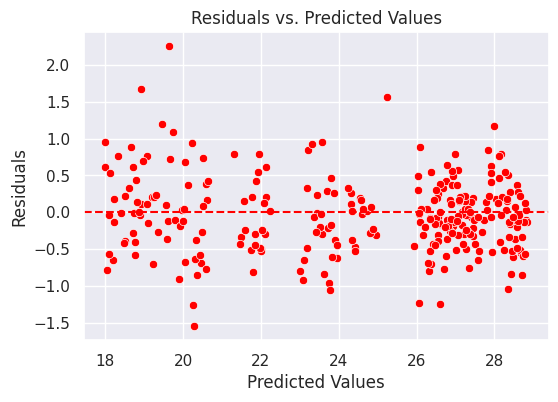




------------------Decision Tree Regression Evaluation----------------------
MSE = MEAN SQUARED ERROR = 0.4969370106761565
RMSE = ROOT MEAN SQUARED ERROR = 0.7049375934621138
MAE = MEAN ABSOLUTE ERROR = 0.5320640569395017
r2 Score = 0.9581542773127842
adjusted r2 score = 0.9561168451220209


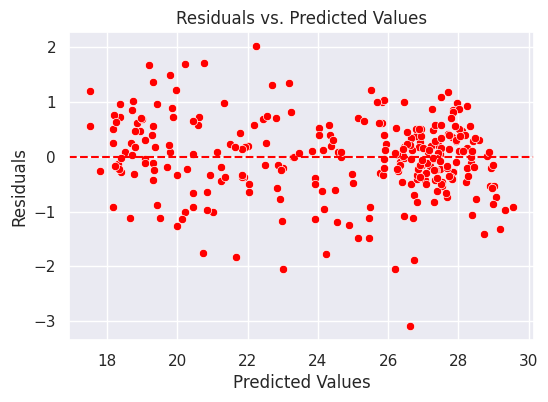




------------------XGboost Regression Evaluation----------------------
MSE = MEAN SQUARED ERROR = 0.2744588985276538
RMSE = ROOT MEAN SQUARED ERROR = 0.523888250037786
MAE = MEAN ABSOLUTE ERROR = 0.4043092940795465
r2 Score = 0.9768885578854352
adjusted r2 score = 0.97576328167761


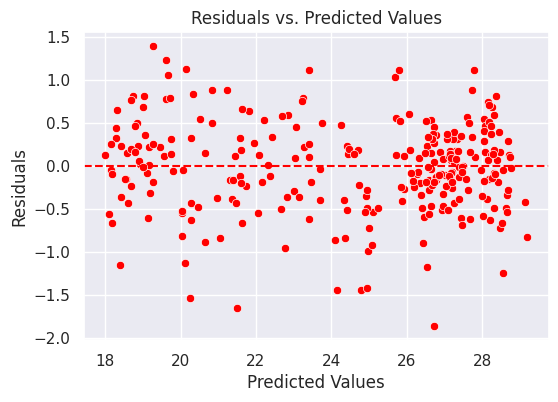




------------------Gradient Boosting Regression Evaluation----------------------
MSE = MEAN SQUARED ERROR = 0.23721669037574078
RMSE = ROOT MEAN SQUARED ERROR = 0.48704896096361894
MAE = MEAN ABSOLUTE ERROR = 0.3692958641613865
r2 Score = 0.9800246235861243
adjusted r2 score = 0.9790520397157858


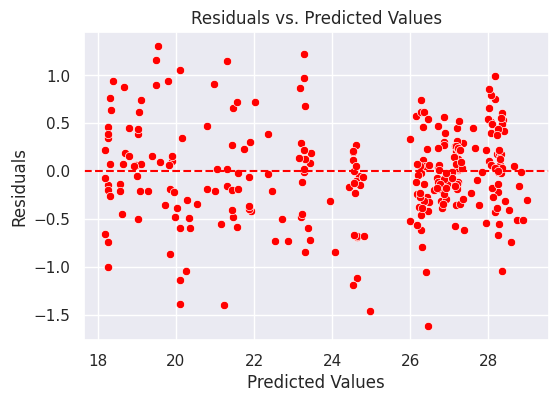

In [35]:
print("----------------------Linear Regression Evaluation--------------------------")
evaluate_model_performance( y_test_np, m1_y_pred, X_test)
print("\n\n\n------------------Decision Tree Regression Evaluation----------------------")
evaluate_model_performance( y_test_np, m2_y_pred, X_test)
print("\n\n\n------------------XGboost Regression Evaluation----------------------")
evaluate_model_performance( y_test_np, m3_y_pred, X_test)
print("\n\n\n------------------Gradient Boosting Regression Evaluation----------------------")
evaluate_model_performance( y_test_np, m4_y_pred, X_test)

# **Submission**


### The above model evaluation clearly marks down Gradient boosting model performs accurately than all the other models.

### Submission File

In [36]:
order = ['Month','Temperature','Year']
GB_reg = GB_reg[order]
GB_reg

,Month,Temperature,Year
1404,1,21.144753,2018
1405,2,23.019828,2018
1406,3,25.786756,2018
1407,4,29.151980,2018
1408,5,30.593936,2018
1409,6,29.659182,2018
1410,7,28.456354,2018
1411,8,28.225079,2018
1412,9,27.957735,2018
1413,10,26.944577,2018


In [37]:
GB_reg.to_csv('predictions.csv', index=False)

In [38]:
predictions_df = pd.read_csv('predictions.csv')
#Displaying the prediction Dataframe
print(predictions_df)

    Month  Temperature  Year
0       1    21.144753  2018
1       2    23.019828  2018
2       3    25.786756  2018
3       4    29.151980  2018
4       5    30.593936  2018
5       6    29.659182  2018
6       7    28.456354  2018
7       8    28.225079  2018
8       9    27.957735  2018
9      10    26.944577  2018
10     11    23.888281  2018
11     12    21.414465  2018
